In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# AMI + 날씨 데이터
df = pd.read_csv("../data_csv/amiwea.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp").sort_index()

# XGBoost 예측 결과
pred = pd.read_csv("../data_csv/XGB테스트.csv", parse_dates=["timestamp"])
pred = pred.set_index("timestamp").sort_index()

# 예측값 병합
df["pred"] = pred["pred_xgb"]
df = df.dropna(subset=["pred"])

공통 평가 지표 정의 

In [15]:
def evaluate_metrics(load_series, peak_threshold, ramp_threshold):
    ramp = load_series.diff().abs()

    return {
        "peak_exceed": (load_series > peak_threshold).sum(),
        "avg_ramp": ramp.mean(),
        "risky_ramp": (ramp > ramp_threshold).sum()
    }

Baseline 지표 산출 

In [16]:
# threshold 완화 (90%)
peak_threshold = df["consumption"].quantile(0.90)

# baseline ramp 기준
baseline_ramp = df["consumption"].diff().abs()
ramp_threshold = baseline_ramp.quantile(0.95)

baseline_metrics = evaluate_metrics(
    df["consumption"],
    peak_threshold,
    ramp_threshold
)

baseline_metrics

{'peak_exceed': np.int64(175),
 'avg_ramp': np.float64(4.341395189003437),
 'risky_ramp': np.int64(88)}

ESS 파라미터 공간 정의 

In [17]:
ESS_POWER_RANGE = [2, 4, 6, 8]      # kW
ESS_ENERGY_RANGE = [5, 10, 20]      # kWh

SOC_INIT = 0.5
ALPHA = 0.1    # 예측 기반 완화 강도

규칙 변경된 ESS 제어 시뮬레이션
* threhold = 90%
* pred > 0

In [18]:
def simulate_ess_predictive(load, pred, power_max, energy_max):
    soc = SOC_INIT * energy_max
    load_adj = load.copy()

    for t in range(len(load)):
        if (pred.iloc[t] > 0.9 * peak_threshold) and (soc > 0):
            discharge = min(
                power_max,
                ALPHA * pred.iloc[t],
                soc
            )
            load_adj.iloc[t] -= discharge
            soc -= discharge

    return load_adj

파라미터 Sweep 실행

In [19]:
results = []

for p in ESS_POWER_RANGE:
    for e in ESS_ENERGY_RANGE:
        load_ess = simulate_ess_predictive(
            df["consumption"],
            df["pred"],
            power_max=p,
            energy_max=e
        )

        metrics = evaluate_metrics(
            load_ess,
            peak_threshold,
            ramp_threshold
        )

        metrics.update({
            "power_max": p,
            "energy_max": e
        })

        results.append(metrics)

result_df = pd.DataFrame(results)
result_df

,peak_exceed,avg_ramp,risky_ramp,power_max,energy_max
0,175,4.343197,88,2,5
1,175,4.345053,89,2,10
2,175,4.349535,89,2,20
3,175,4.343197,88,4,5
4,175,4.345053,89,4,10
5,175,4.349535,89,4,20
6,175,4.343197,88,6,5
7,175,4.345053,89,6,10
8,175,4.349535,89,6,20
9,175,4.343197,88,8,5


Trade-off 시각화 (Peak vs ESS Power)

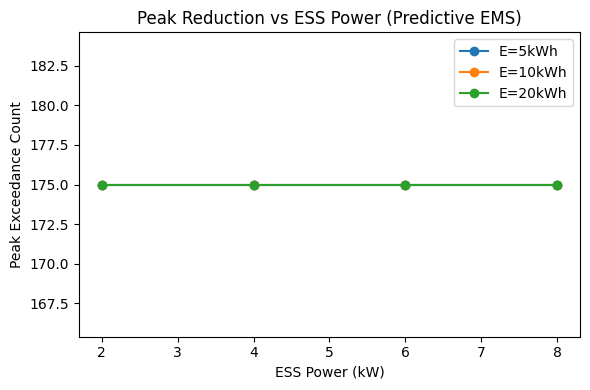

In [20]:
plt.figure(figsize=(6,4))
for e in ESS_ENERGY_RANGE:
    subset = result_df[result_df["energy_max"] == e]
    plt.plot(subset["power_max"], subset["peak_exceed"],
             marker="o", label=f"E={e}kWh")

plt.xlabel("ESS Power (kW)")
plt.ylabel("Peak Exceedance Count")
plt.title("Peak Reduction vs ESS Power (Predictive EMS)")
plt.legend()
plt.tight_layout()
plt.show()

Trade-off 시각화 (Peak vs Stability Proxy)

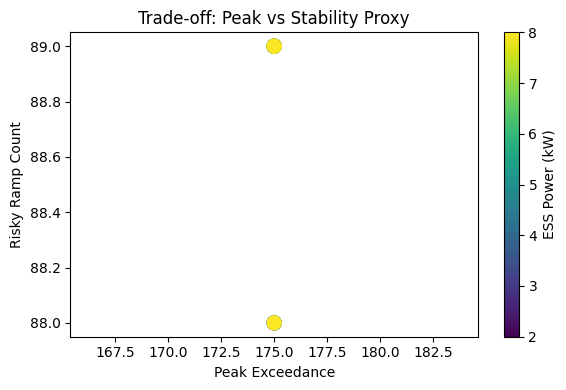

In [21]:
plt.figure(figsize=(6,4))
plt.scatter(
    result_df["peak_exceed"],
    result_df["risky_ramp"],
    c=result_df["power_max"],
    s=100,
    cmap="viridis"
)

plt.xlabel("Peak Exceedance")
plt.ylabel("Risky Ramp Count")
plt.colorbar(label="ESS Power (kW)")
plt.title("Trade-off: Peak vs Stability Proxy")
plt.tight_layout()
plt.show()

본 실험에서는 ESS 파라미터를 sweep하였으나 지표 변화가 제한적으로 나타났으며, 이를 통해 grid-forming 안정성 확보에는 하드웨어 용량 증대보다 제어 로직 설계가 핵심적임을 확인하였다.